In [1]:
from __future__ import print_function

import keras
from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from keras.models import load_model
import tensorflow

import h5py
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

Using TensorFlow backend.


In [2]:
shuffled_df = pd.read_csv("bal_shuffled_df.csv", index_col=0)

In [3]:
texts = shuffled_df["Text"].tolist()  # list of text samples
labels_index = {}  # dictionary mapping label name to numeric id
labels = shuffled_df["Category"].tolist()  # list of label ids


In [4]:
len(texts)

206684

In [5]:
len(labels)

206684

In [4]:
import re

def remove_html_tags(data):
    p = re.compile(r'<.*?>')
    return p.sub('', data)

cleantexts = []

for i in range(len(texts)):
    para = str(texts[i])
    #print(para)
    #print(type(para))
    cleantext = remove_html_tags(para)
    cleantexts.append(cleantext)
    
    

In [7]:
type(labels[0])

str

In [9]:
labels_index = {}

categories = ["ai", 
              "batterytech", 
              "blackswans", 
              "blockchain", 
              "carboneradication", 
              "cpr_articles", 
              "digitalads", 
              "digitalcurrency",
              "digitalhealth", 
              "educationtech", 
              "financialservices", 
              "internetofthings", 
              "property", 
              "sharingeconomy"]

cleanlabels = []

for name in categories:
    label_id = len(labels_index)
    labels_index[name] = label_id
    
for label in labels:
    cleanlabels.append(labels_index[label])
    

In [10]:
len(labels_index)
print(labels_index)

{'ai': 0, 'batterytech': 1, 'blackswans': 2, 'blockchain': 3, 'carboneradication': 4, 'cpr_articles': 5, 'digitalads': 6, 'digitalcurrency': 7, 'digitalhealth': 8, 'educationtech': 9, 'financialservices': 10, 'internetofthings': 11, 'property': 12, 'sharingeconomy': 13}


In [11]:
categories[0]


'ai'

In [11]:
texts[-8697]


'Route 66 prepares to go solar via crowdfunding<p>Route 66, one of America’s oldest and most famous roads, may soon be its first to go solar as the Missouri state transport department is hoping to add photovoltaic solar pavers to a section of the road this year. Interestingly, the state government will turn to crowdfunding to fund the project. The announcement is part of <a href="http://www.architecturaldigest.com/story/iconic-route-66-americas-first-solar-roadway">Missouri’s Road to Tomorrow Initiative</a>, which aims to integrate modern technology into the state’s transportation system (other plans include \'truck platooning\', which connects commercial vehicles through wireless technology, allowing them to follow one another at close distances for better fuel economy through wind resistance).</p>\n'

In [5]:
# Functions for F1 Recall and Precision metrics

from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall))




In [12]:
def to_categorical(y, nb_classes=None):
    y = np.asarray(y, dtype='int32')

    if not nb_classes:
        nb_classes = np.max(y) + 1

    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        Y[i, y[i]] = 1.

    return Y

In [13]:
nb_validation_samples = int(0.2 * len(cleantexts))
nb_validation_samples
num_classes = 14

In [14]:
import numpy as np
import pandas as pd
import tensorflow
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, Activation
from keras.layers import Embedding, Input, Dense, Dropout, Lambda, MaxPooling1D
from keras.optimizers import SGD
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint

#len(ALPHABET)=68
ALPHABET = 'abcdefghijklmnopqrstuvwxyz0123456789-,;.!?:’"/|_#$%ˆ&*˜‘+=<>()[]{} '
FEATURE_LEN = 1024 #maxlen
#path = '../data/'
#TRAIN_DATA_FILE=path+'train.csv'
#TEST_DATA_FILE=path+'test.csv'


def get_char_dict():
    char_dict={}
    for i,c in enumerate(ALPHABET):
        char_dict[c]=i+1
    return char_dict

def char2vec(text, max_length=FEATURE_LEN):
    char_dict = get_char_dict()
    data=np.zeros(max_length)
    
    for i in range(0, len(text)):
        if i >= max_length:
            return data
        
        elif text[i] in char_dict:
            data[i] = char_dict[text[i]]
        
        else:
            data[i]=68
    return data
    

#train_df = pd.read_csv(TRAIN_DATA_FILE)
#test_df = pd.read_csv(TEST_DATA_FILE)

#dataset where x=train_df['text'] and y=train_df['class'] 
#binary class
list_sentences_train = cleantexts[:-nb_validation_samples] #train_df["text"].fillna("NA").values
y = cleanlabels[:-nb_validation_samples] #train_df['class'].values
y = to_categorical(y, num_classes)
list_sentences_test = cleantexts[-nb_validation_samples:] #test_df["text"].fillna("NA").values
y_val = cleanlabels[-nb_validation_samples:] #train_df['class'].values
y_val = to_categorical(y_val, num_classes)

data=[]
for text in list_sentences_train:
    data.append(char2vec(text.lower()))
data=np.array(data)

test_data = []
for text in list_sentences_test:
    test_data.append(char2vec(text.lower()))
test_data=np.array(test_data)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
y = y[indices]

test_indices = np.arange(test_data.shape[0])
np.random.shuffle(test_indices)
test_data = test_data[test_indices]
y_val = y_val[test_indices]


In [16]:
data.shape

(165348, 1024)

In [15]:
# The VDCNN...


def conv_shape(conv):
    return conv.get_shape().as_list()[1:]


def ConvolutionalBlock(input_shape, num_filters):
    model=Sequential()

    #1st conv layer
    model.add(Conv1D(filters = num_filters, kernel_size = 3, strides = 1, padding = "same", input_shape = input_shape))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    #2nd conv layer
    model.add(Conv1D(filters = num_filters, kernel_size = 3, strides = 1, padding = "same"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))

    return model

#https://www.tensorflow.org/api_docs/python/tf/nn/top_k
def top_kmax(x):
    x=tensorflow.transpose(x, [0, 2, 1])
    k_max = tensorflow.nn.top_k(x, k=top_k)
    return tensorflow.reshape(k_max[0], (-1, num_filters[-1]*top_k))

def vdcnn_model(num_filters, num_classes, sequence_max_length, num_chars, embedding_size, top_k, learning_rate=0.001):
    
    inputs=Input(shape=(sequence_max_length, ), dtype='int32', name='input')
    
    embedded_seq = Embedding(num_chars, embedding_size, input_length=sequence_max_length)(inputs)
    embedded_seq = BatchNormalization()(embedded_seq)
    #1st Layer
    conv = Conv1D(filters=64, kernel_size=3, strides=2, padding="same")(embedded_seq)
    
    #ConvBlocks
    for i in range(len(num_filters)):
        conv = ConvolutionalBlock(conv_shape(conv), num_filters[i])(conv)
        conv = MaxPooling1D(pool_size=3, strides=2, padding="same")(conv)
        
    def _top_k(x):
        x = tensorflow.transpose(x, [0, 2, 1])
        k_max = tensorflow.nn.top_k(x, k=top_k)
        return tensorflow.reshape(k_max[0], (-1, num_filters[-1] * top_k))
    
    k_max = Lambda(_top_k, output_shape=(num_filters[-1] * top_k,))(conv)
    
    #fully connected layers
    # in original paper they didn't used dropouts
    fc1=Dense(512, activation='relu', kernel_initializer='he_normal')(k_max)
    fc1=Dropout(0.3)(fc1)
    fc2=Dense(512, activation='relu', kernel_initializer='he_normal')(fc1)
    fc2=Dropout(0.3)(fc2)
    out=Dense(num_classes, activation='softmax')(fc2)
    
    #optimizer
    sgd = SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=False)
    
    model = Model(inputs=inputs, outputs=out)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

num_filters = [64, 128, 256, 512]
model=vdcnn_model(num_filters=num_filters, num_classes=14, num_chars=69, sequence_max_length=FEATURE_LEN,embedding_size=16,top_k=3)
model.summary()
model.fit(data, y, 
          epochs=1, 
          validation_data=(test_data, y_val)) 




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1024)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 1024, 16)          1104      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1024, 16)          64        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 512, 64)           3136      
_________________________________________________________________
sequential_1 (Sequential)    (None, 512, 64)           25216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 256, 64)           0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 256, 128)          75008     
__________

In [16]:
model.save('vdcnn_1_epochs.h5')

In [19]:
model.predict(test_data) 

array([[ 0.06692445,  0.08511326,  0.08259252, ...,  0.05552863,
         0.07286651,  0.07488403],
       [ 0.07075118,  0.04943388,  0.02784937, ...,  0.22828455,
         0.0335046 ,  0.02677826],
       [ 0.07985143,  0.0699251 ,  0.0604816 , ...,  0.08931252,
         0.0717829 ,  0.06414209],
       ..., 
       [ 0.06714302,  0.05623567,  0.0548824 , ...,  0.09415884,
         0.07094546,  0.07108492],
       [ 0.07282635,  0.08532099,  0.07648936, ...,  0.0627922 ,
         0.07324773,  0.07091171],
       [ 0.08123972,  0.0750981 ,  0.062119  , ...,  0.09052143,
         0.06740658,  0.05961941]], dtype=float32)

In [24]:

model = load_model('vdcnn_1_epochs.h5')

NameError: name 'tf' is not defined

In [48]:
# Evaluate the accuracy of our trained model
score = model.evaluate(test_data, y_val,
                       batch_size=32, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])


41336/41336 [==============================] - 595s 14ms/step
Test score: 0.464921756319
Test accuracy: 0.795342981273


In [47]:
y_softmax = model.predict(test_data)

y_test_1d = []
y_pred_1d = []

for i in range(len(test_data)):
    probs = y_val[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [49]:
import matplotlib.pyplot as plt

# This utility function is from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

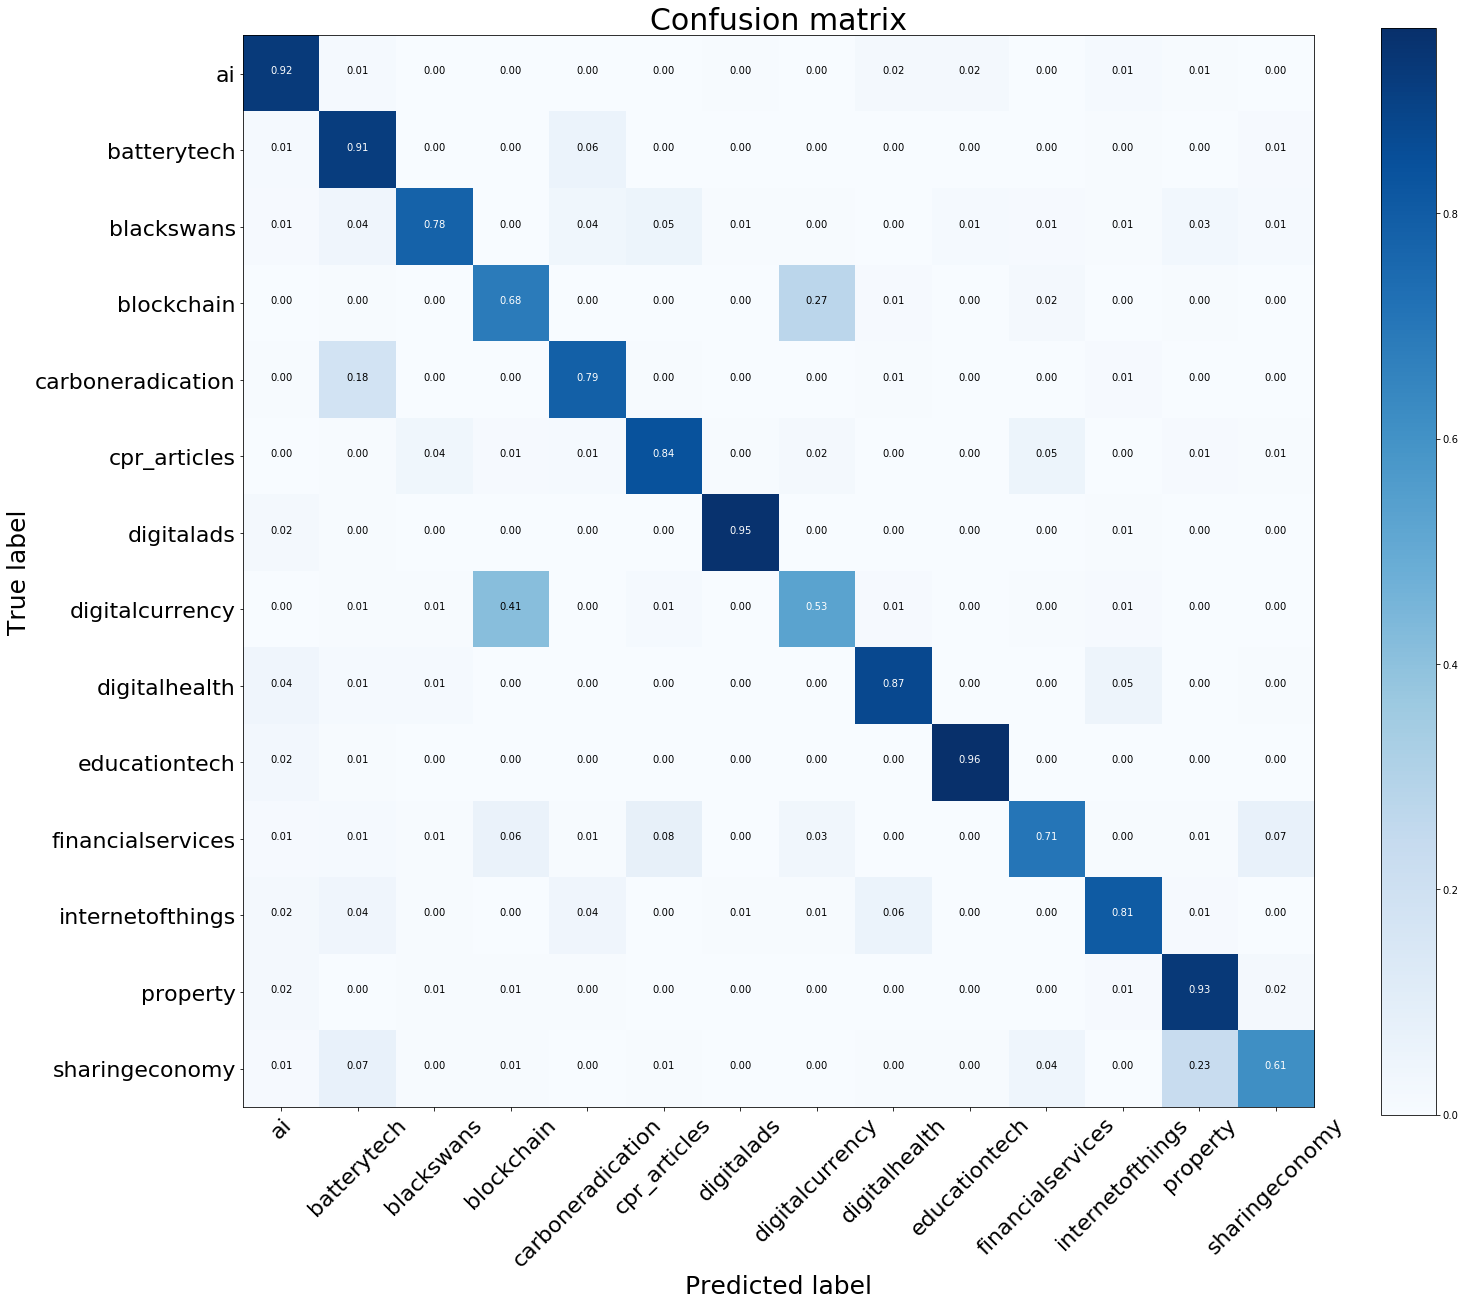

In [50]:
import itertools
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize=(24,20))
plot_confusion_matrix(cnf_matrix, classes=categories, title="Confusion matrix")
plt.show()

In [51]:
cleantexts[1]

"UK regulators back Barclays' deal with Bitcoin firm\nThe UK financial regulator, the FCA, has approved Barclays' partnership deal with Bitcoin firm Circle, in what reports describe as a sign that regulators are overcoming their previously held reservations over the cryptocurrency. Several figures in various UK authoritative bodies have commented on the country's aim of having London become the FinTech hub of the world, so this may not come as a complete surprise.\n"

In [52]:
labels[1]

'digitalcurrency'

In [21]:
# Here's how to predict a category for an individual example by tokenizing it first

number_of_text = 1

text_to_predict = cleantexts[number_of_text]
print(text_to_predict)

trans_text = char2vec(text_to_predict.lower())

text_list = []
text_list.append(trans_text)
text_list=np.array(text_list)

prediction = model.predict(np.array(text_list))
print(prediction, "\n")

predicted_label = categories[np.argmax(prediction)]
print("Predicted Category number: ", np.argmax(prediction))
print("Predicted Category name: ", predicted_label)
print("Actual Category name: ", labels[number_of_text], "\n\n")


UK regulators back Barclays' deal with Bitcoin firm
The UK financial regulator, the FCA, has approved Barclays' partnership deal with Bitcoin firm Circle, in what reports describe as a sign that regulators are overcoming their previously held reservations over the cryptocurrency. Several figures in various UK authoritative bodies have commented on the country's aim of having London become the FinTech hub of the world, so this may not come as a complete surprise.

[[ 0.06692445  0.08511326  0.08259252  0.0772478   0.07621425  0.06063227
   0.06550975  0.08932478  0.06488284  0.0604795   0.06779941  0.05552863
   0.07286651  0.07488403]] 

Predicted Category number:  7
Predicted Category name:  digitalcurrency
Actual Category name:  digitalcurrency 




In [54]:
# Here's how predict a series of texts

for i in range(10):
    number_of_text = i+40000

    text_to_predict = cleantexts[number_of_text]
    print(text_to_predict)

    trans_text = char2vec(text_to_predict.lower())

    text_list = []
    text_list.append(trans_text)
    text_list=np.array(text_list)

    prediction = model.predict(np.array(text_list))
    print(prediction, "\n")

    predicted_label = categories[np.argmax(prediction)]
    print("Predicted Category number: ", np.argmax(prediction))
    print("Predicted Category name: ", predicted_label)
    print("Actual Category name: ", labels[number_of_text], "\n\n")
    

Myanmar to speed up property rules liberalisation after upcoming electionAn upcoming election in Myanmar may cause a liberalisation of the country's property ownership rules, including allowing foreigners to directly own Myanmar property for the first time. Investment and activity in the market has slowed up the run-up to the election amid uncertainty, but this report suggests that after the election foreign investment could accelerate to levels not seen before in the country. The election will take place on Sunday, 8th November.

[[  3.88419676e-06   1.55761313e-07   1.10766524e-02   2.39300935e-08
    5.03748539e-04   2.83754338e-03   2.90427504e-08   2.17388973e-09
    2.10082640e-09   9.93815803e-08   1.00030229e-04   3.79923961e-07
    9.85348403e-01   1.29046035e-04]] 

Predicted Category number:  12
Predicted Category name:  property
Actual Category name:  property 


Hotel booking app, HotelTonight, lays off 20% of its staffHotelTonight, the app-based hotel booking service, has